In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np
import tensorflow as tf
from dsn.util.systems import V1Circuit
from dsn.train_dsn import train_dsn
from dsn.util.plot_util import assess_constraints, pairplot
import seaborn as sns
import pandas as pd
import warnings
import scipy
import time
warnings.filterwarnings("ignore")
import os

os.chdir('../../')

In [2]:
# set fixed params

"""
base_I = 0.0
run_I = 1.0
fixed_params = {'b_E':base_I, \
                'b_P':base_I, \
                'b_S':base_I, \
                'b_V':base_I, \
                'h_RUNE':run_I, \
                'h_RUNP':run_I, \
                'h_RUNS':run_I, \
                'h_RUNV':run_I, \
                'h_FFE':0.0, \
                'h_FFP':0.0, \
                'h_LATE':0.0, \
                'h_LATP':0.0, \
                'h_LATS':0.0, \
                'h_LATV':0.0, \
                'n':2.0, \
                's_0':30}"""

fixed_params = {'h_FFE':0.0, \
                'h_FFP':0.0, \
                'h_LATE':0.0, \
                'h_LATP':0.0, \
                'h_LATS':0.0, \
                'h_LATV':0.0, \
                'n':2.0, \
                's_0':30}

behavior_type = "difference"

c_vals=np.array([1.0])
s_vals=np.array([60])
r_vals=np.array([0.0, 1.0])

behavior = {'type':behavior_type, \
            'c_vals':c_vals, \
            's_vals':s_vals, \
            'r_vals':r_vals, \
            'fac':10.0}

# set model options
model_opts = {"g_FF": "c", "g_LAT": "square", "g_RUN": "r"}
T = 200
dt = 0.05
init_conds = np.expand_dims(np.array([1.0, 1.1, 1.2, 1.3]), 1)

system = V1Circuit(fixed_params, behavior, model_opts, T, dt, init_conds)

print('mu', system.mu)


mu [0.0251065  0.04960956 0.07151498 0.01784181 0.00064484 0.00247898
 0.00515613 0.0004019 ]


In [3]:
M = 2000
taus = [0.15]

num_taus = len(taus)

max_I = 2.0
#base_I = np.random.uniform(0.0, max_I, (M,))
base_I = 0.15*np.ones((M,))
b_E = base_I
b_P = base_I
b_S = base_I
b_V = base_I

#run_I = np.random.uniform(0.00, max_I, (M,))
run_I = 0.3*np.ones((M,))
h_RUNE = run_I
h_RUNP = run_I
h_RUNS = run_I
h_RUNV = run_I

max_W = 5.0
max_WE = 5.0
# column 1
W_E = np.random.uniform(0.0, max_WE, (M,))
W_EE = W_E
W_PE = W_E
W_SE = W_E
W_VE = W_E
"""W_EE = np.random.uniform(0.0, max_WE, (M,))
W_PE = np.random.uniform(0.0, max_WE, (M,))
W_SE = np.random.uniform(0.0, max_WE, (M,))
W_VE = np.random.uniform(0.0, max_WE, (M,))"""

# column 2
W_EP = np.random.uniform(0.0, max_W, (M,))
W_PP = np.random.uniform(0.0, max_W, (M,))
W_VP = np.random.uniform(0.0, max_W, (M,))

# column 3
W_ES = np.random.uniform(0.0, max_W, (M,))
W_PS = np.random.uniform(0.0, max_W, (M,))
W_VS = np.random.uniform(0.0, max_W, (M,))

# column 4
W_SV = np.random.uniform(0.0, max_W, (M,))

tau = np.zeros((M,))

_Z = np.stack((W_E, W_EP, W_PP, W_VP, W_ES, W_PS, W_VS, W_SV, \
               b_E, b_P, b_S, b_V, h_RUNE, h_RUNP, h_RUNS, h_RUNP, tau), axis=1)
_Z = np.expand_dims(_Z, 0)


In [4]:
num_params = system.D;
Z = tf.placeholder(dtype=tf.float64, shape=(1, None, num_params));

sess = tf.Session()
T_x = system.simulation_suff_stats(Z)
r_t = system.simulate(Z)

In [5]:
_T_xs = []
_r_ts = []
for i in range(num_taus):
    _tau = taus[i]
    _Z[0,:,-1] = _tau
    _T_x, _r_t = sess.run([T_x, r_t], {Z:_Z});
    _T_xs.append(_T_x)
    _r_ts.append(_r_t)


tau 0.15


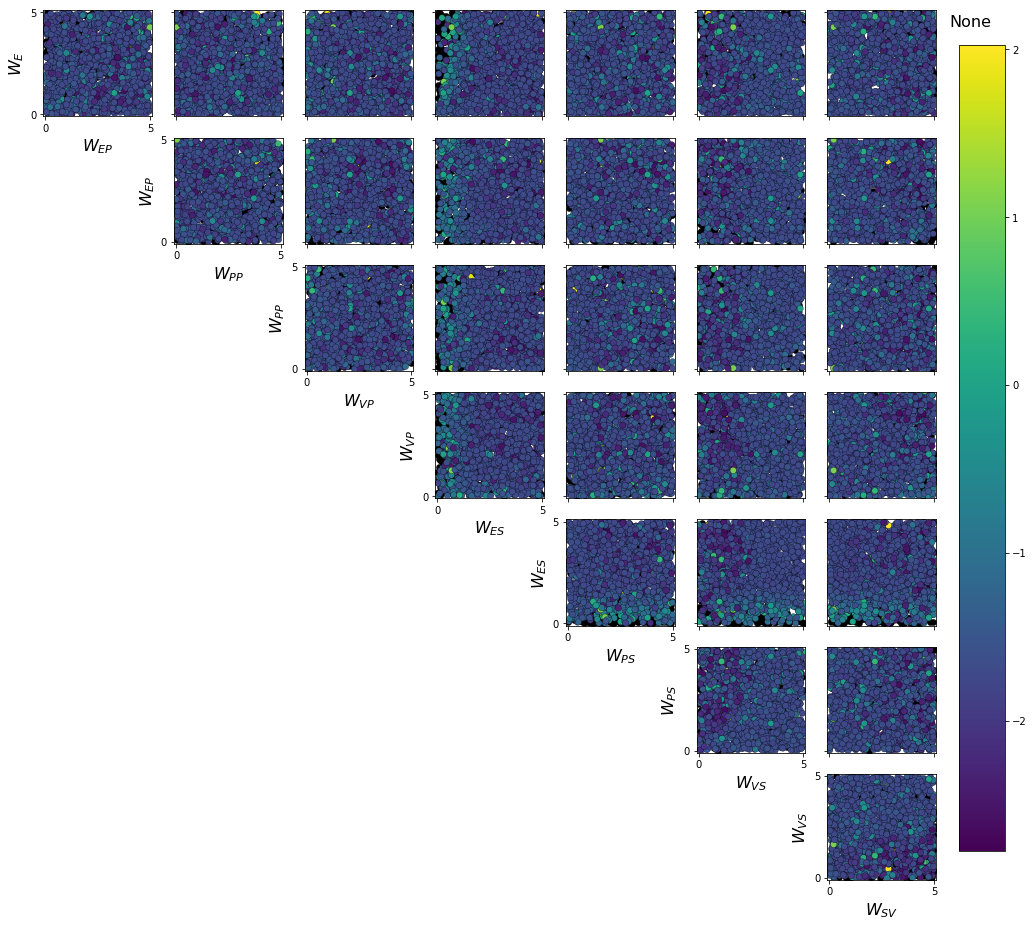

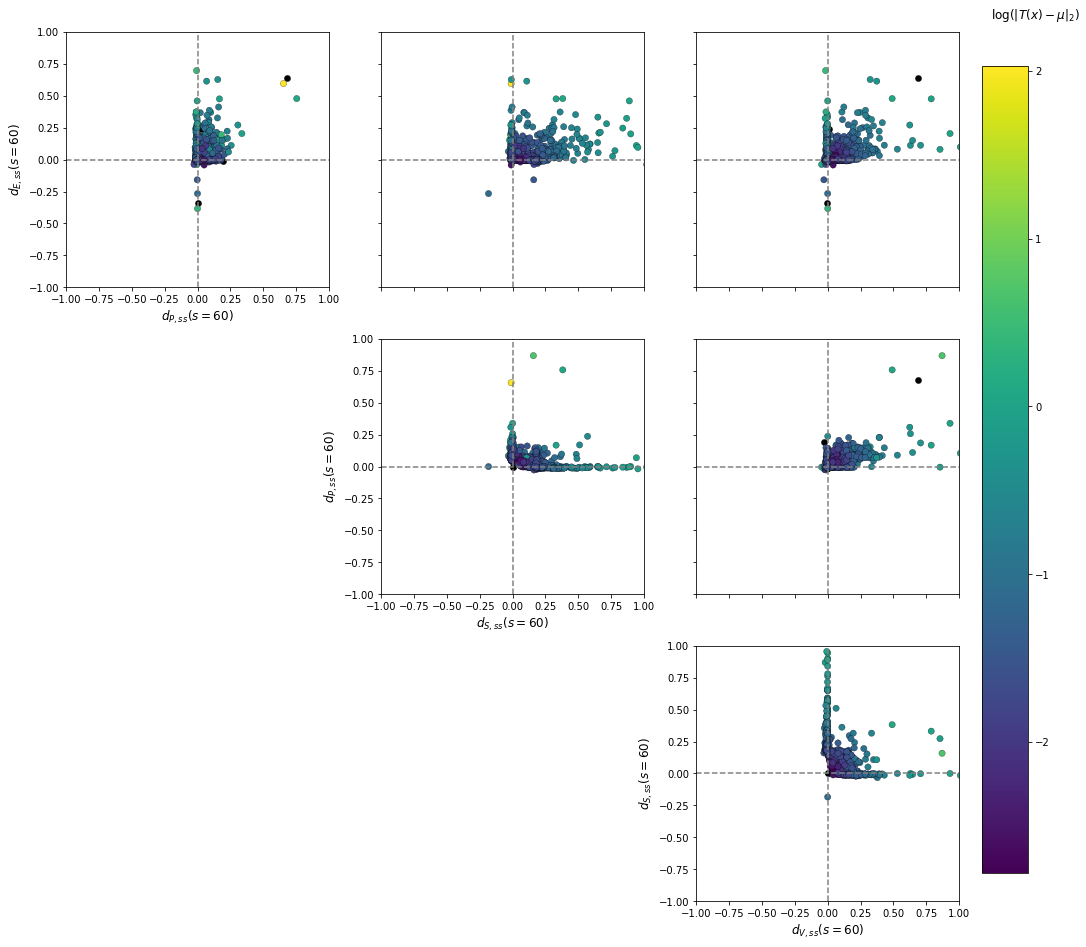

In [6]:
from operator import itemgetter
plot_inds = [0,1,2,3,4,5,6,7]
nparams = len(plot_inds)
plot_z_labels = []
for i in range(nparams):
    plot_z_labels.append(system.z_labels[plot_inds[i]])

ax_buf = 0.1
log_ds = []
for i in range(num_taus):
    _T_x = _T_xs[i]
    _tau = taus[i]
    print('tau', _tau)
    _T_x_mu_centered = _T_x - np.expand_dims(np.expand_dims(system.mu, 0), 0)
    d = np.linalg.norm(_T_x[0,:,:system.num_suff_stats//2] - \
                       np.expand_dims(system.mu[system.num_suff_stats//2], 0), axis=1)
    d_cutoff = 10
    d[d > d_cutoff] = d_cutoff
    log_d = np.log(d)
    log_ds.append(log_d)
    
    lims = [-ax_buf, 5.0+ax_buf]
    ticks = np.arange(0, 20, 5)

    fig = pairplot(_Z[0], plot_inds, plot_z_labels, origin=False, \
                           c=log_d, c_label=None, cmap=None, \
                           xlims=lims, ylims=lims, ticks=ticks, fontsize=16, \
                           figsize=(16,16), pfname=None)
    
    fig = pairplot(_T_x[0], range(system.num_suff_stats//2), system.T_x_labels, origin=True, \
                       c=log_d, c_label=r'$\log(|T(x)-\mu|_2)$', cmap=None, \
                       xlims=[-1, 1], ylims=[-1, 1], ticks=None, fontsize=12, \
                       figsize=(16,16), pfname=None)

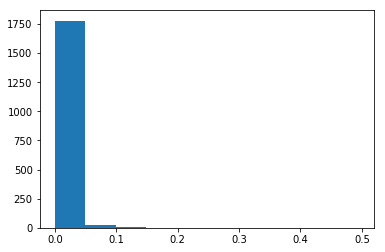

In [8]:
plt.figure()
plt.hist(r_ss[0,inds,0])
plt.show()

(2, 2000, 4)
(1, 2000, 17)
[ True  True  True ...  True  True  True]


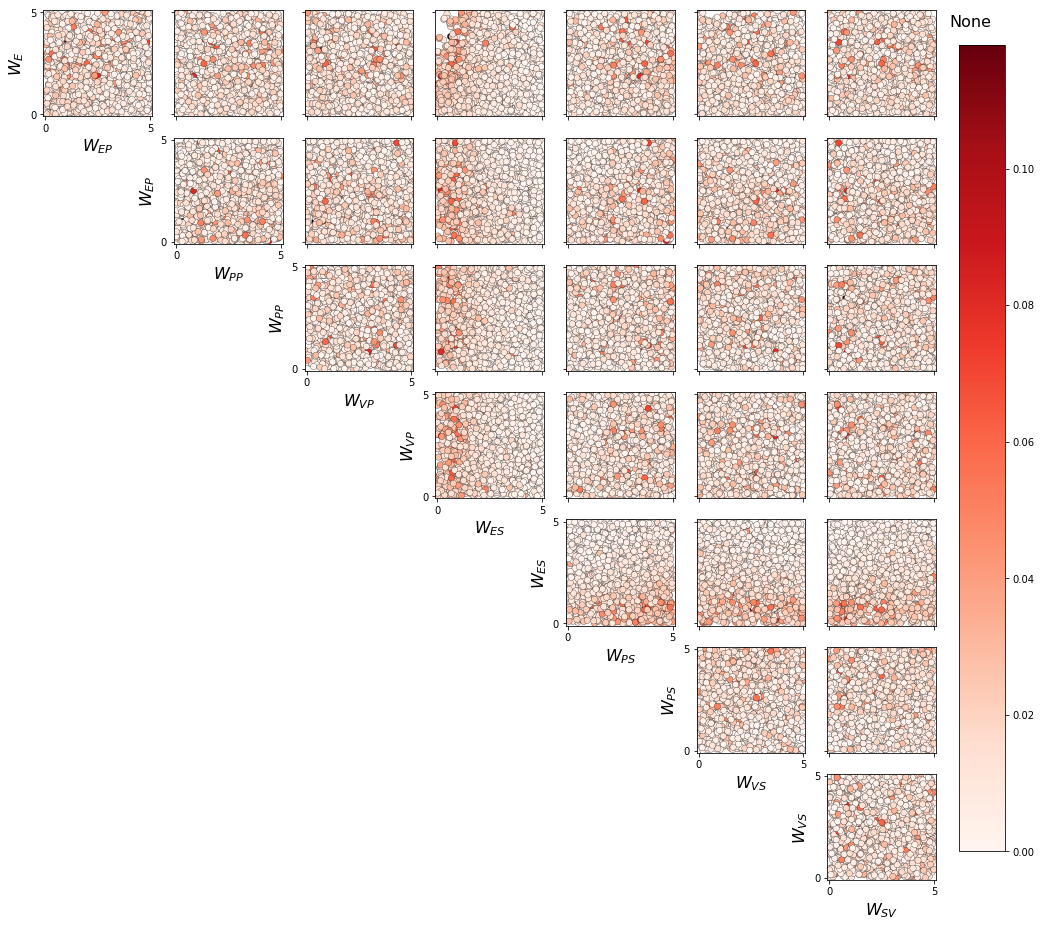

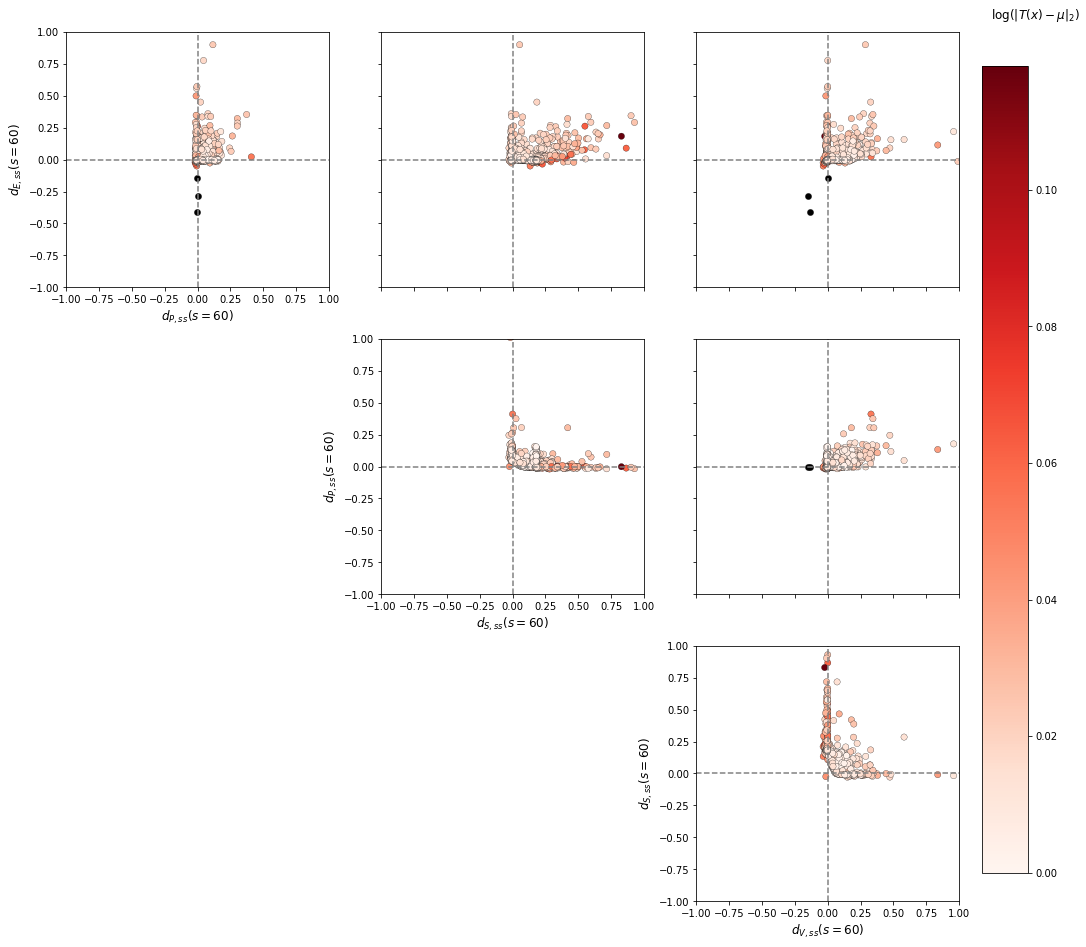

In [7]:
r_ss = _r_ts[0][-1,:,:,:,0]
inds = r_ss[0,:,0] < 10.0
print(r_ss.shape)
print(_Z.shape)
print(inds)

for i in range(num_taus):
    _T_x = _T_xs[i]
    _tau = taus[i]

    _T_x_mu_centered = _T_x - np.expand_dims(np.expand_dims(system.mu, 0), 0)

    fig = pairplot(_Z[0,inds], plot_inds, plot_z_labels, origin=False, \
                           c=r_ss[0,inds,0], c_label=None, cmap=plt.get_cmap('Reds'), \
                           xlims=lims, ylims=lims, ticks=ticks, fontsize=16, \
                           figsize=(16,16), pfname=None, outlier_stds=6)
    
    fig = pairplot(_T_x[0,inds], range(system.num_suff_stats//2), system.T_x_labels, origin=True, \
                       c=r_ss[0,inds,0], c_label=r'$\log(|T(x)-\mu|_2)$', cmap=plt.get_cmap('Reds'), \
                       xlims=[-1, 1], ylims=[-1, 1], ticks=None, fontsize=12, \
                       figsize=(16,16), pfname=None, outlier_stds=6)
    
    

In [9]:
W, b, h_FF, h_LAT, h_RUN, tau, n, s_0, a, c_50 = system.filter_Z(Z)

with tf.Session() as sess:
    _W, _b, _h_RUN = sess.run([W, b, h_RUN], {Z:_Z})
    
run = False

if (run):
    r_ss = _r_t[:,1,:,:,0].T
    u = np.zeros((M, 4))
    for i in range(M):
        u[i,:] = np.dot(_W[0,i,:,:], r_ss[:,i,-2]) + _h_RUN[0,i,:,0]
else:
    r_ss = _r_t[:,0,:,:,0].T
    u = np.zeros((M, 4))
    for i in range(M):
        u[i,:] = np.dot(_W[0,i,:,:], r_ss[:,i,-2]) + _b[0,i,:,0]

r_ss_E = r_ss[0,:,-1]
u_E = u[:,0]

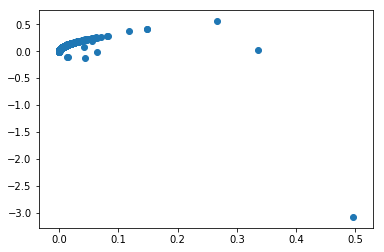

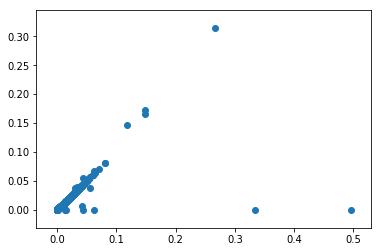

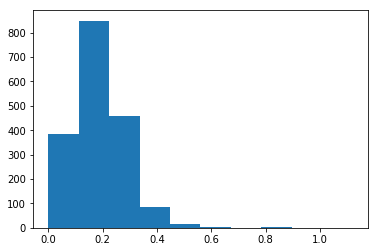

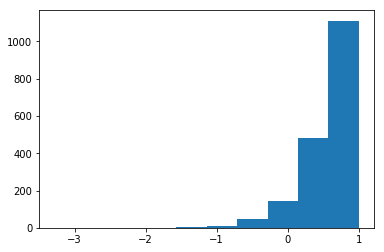

In [10]:
inds = np.logical_and(np.abs(r_ss_E) < 10.0, np.abs(u_E) < 10.0)
plt.figure()
plt.scatter(r_ss_E[inds], u_E[inds])
plt.show()

rect_u_E = u_E.copy()
rect_u_E[rect_u_E < 0] = 0.0
plt.figure()
plt.scatter(r_ss_E[inds], np.square(rect_u_E[inds]))
plt.show()

gamma = 2*rect_u_E[inds]
plt.figure()
plt.hist(gamma)
plt.show()

x = _Z[0,inds,0]*gamma
y = 1-x
plt.figure()
plt.hist(y)
plt.show()

(200, 147)


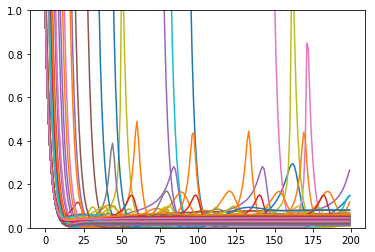

In [11]:
yinds = y < 0

_r_t_y = _r_t[:,0,inds,0,0][:,yinds]
print(_r_t_y.shape)
plt.figure()
plt.plot(_r_t_y)
plt.ylim([0,1])
plt.show()

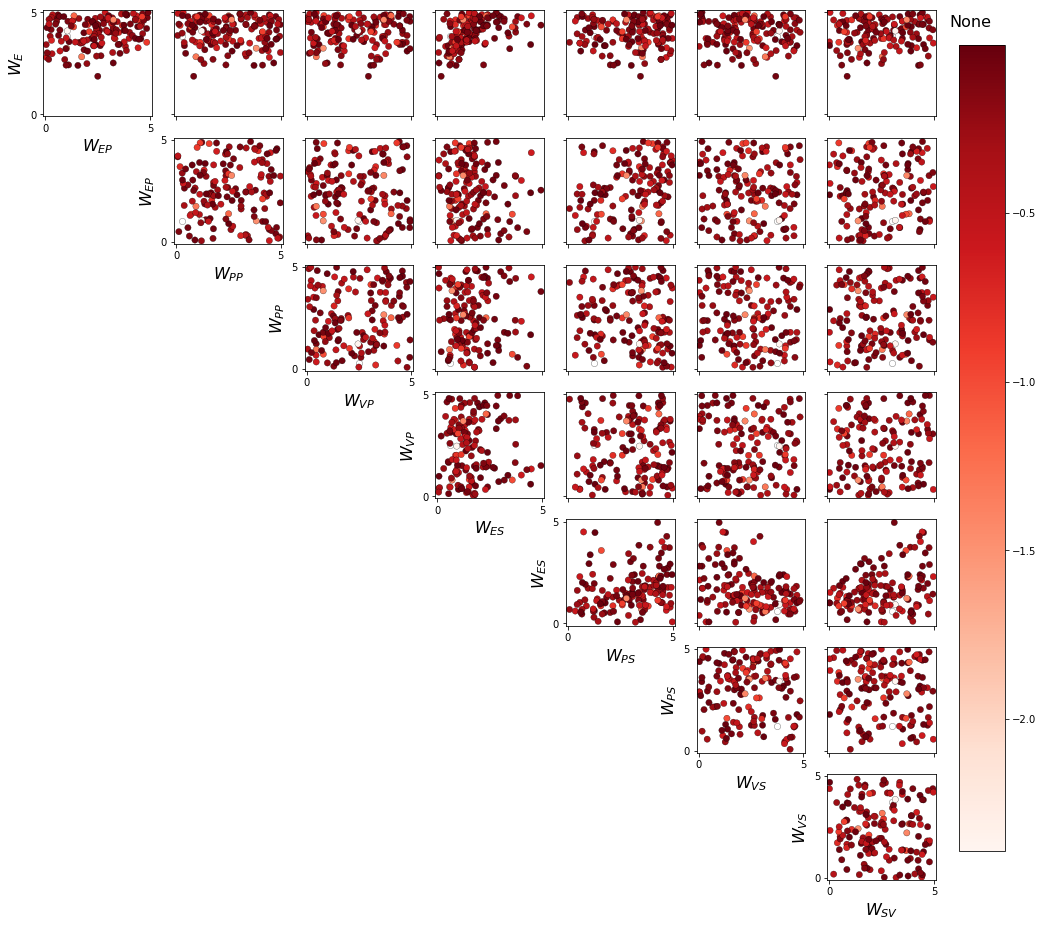

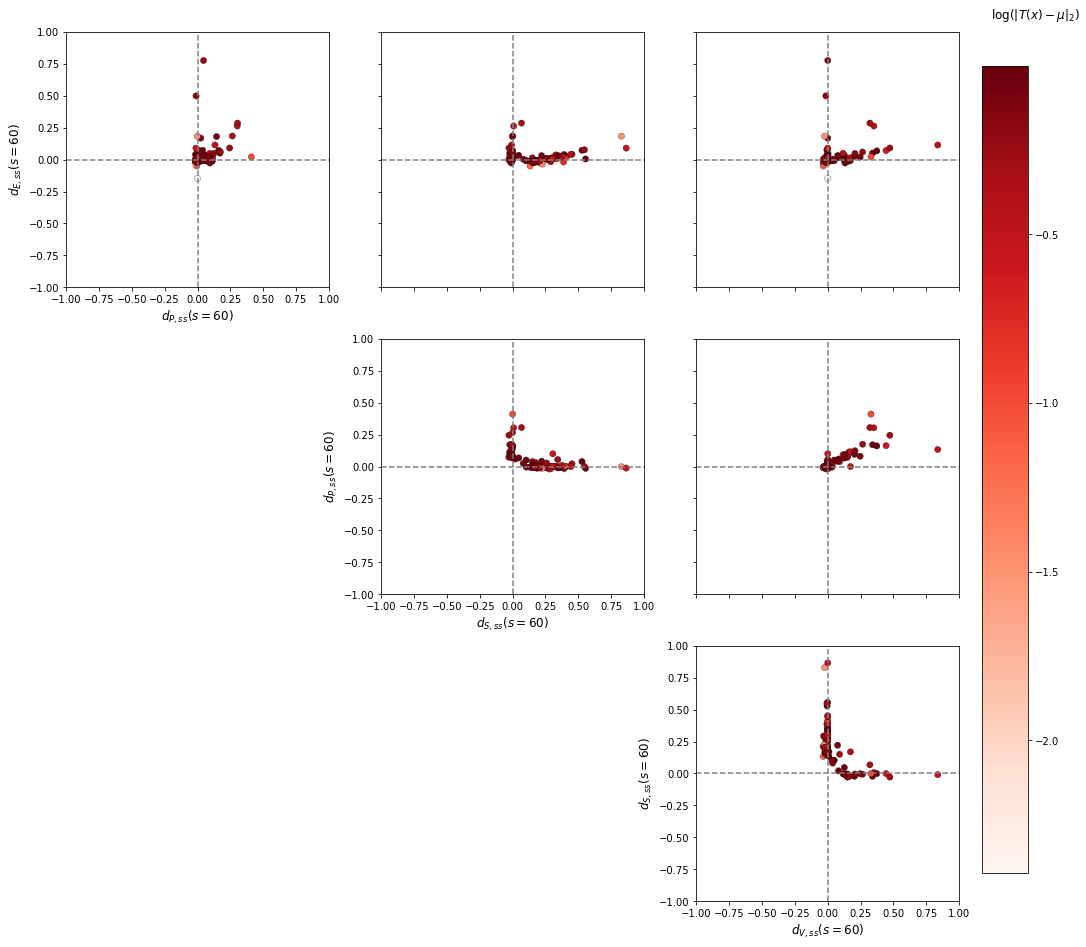

In [12]:

for i in range(num_taus):
    _T_x = _T_xs[i]
    _tau = taus[i]

    _T_x_mu_centered = _T_x - np.expand_dims(np.expand_dims(system.mu, 0), 0)

    fig = pairplot(_Z[0,inds][yinds], plot_inds, plot_z_labels, origin=False, \
                           c=y[yinds], c_label=None, cmap=plt.get_cmap('Reds'), \
                           xlims=lims, ylims=lims, ticks=ticks, fontsize=16, \
                           figsize=(16,16), pfname=None, outlier_stds=6)
    
    fig = pairplot(_T_x[0,inds][yinds], range(system.num_suff_stats//2), system.T_x_labels, origin=True, \
                       c=y[yinds], c_label=r'$\log(|T(x)-\mu|_2)$', cmap=plt.get_cmap('Reds'), \
                       xlims=[-1, 1], ylims=[-1, 1], ticks=None, fontsize=12, \
                       figsize=(16,16), pfname=None, outlier_stds=6)
    
    

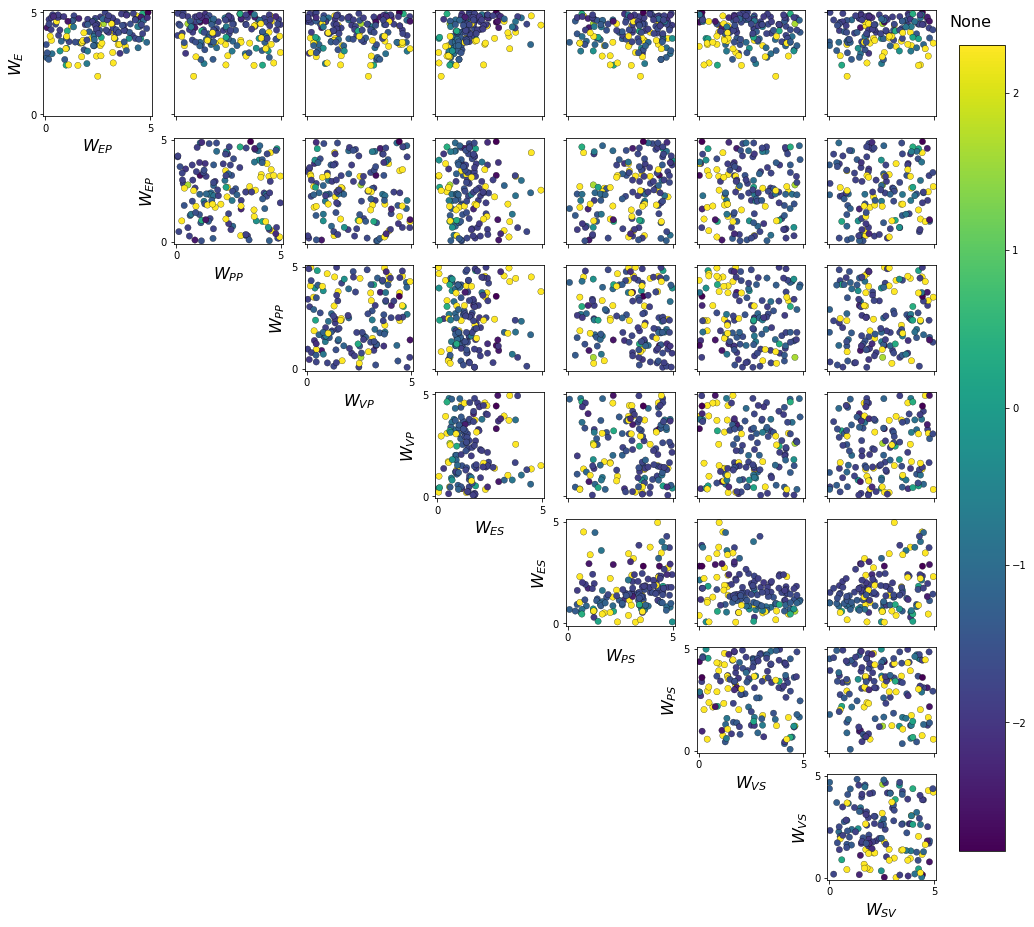

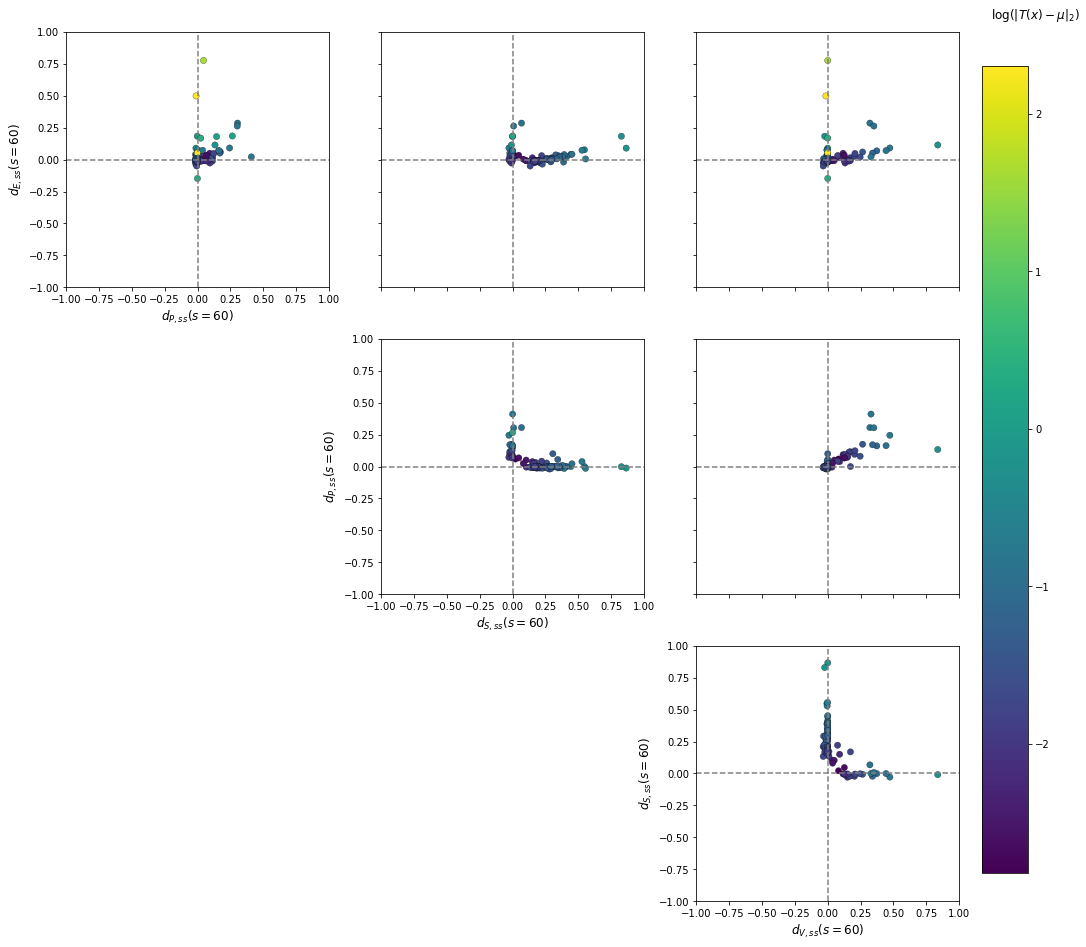

In [14]:

for i in range(num_taus):
    _T_x = _T_xs[i]
    _tau = taus[i]

    _T_x_mu_centered = _T_x - np.expand_dims(np.expand_dims(system.mu, 0), 0)

    fig = pairplot(_Z[0,inds][yinds], plot_inds, plot_z_labels, origin=False, \
                           c=log_d[inds][yinds], c_label=None, 
                           xlims=lims, ylims=lims, ticks=ticks, fontsize=16, \
                           figsize=(16,16), pfname=None, outlier_stds=6)
    
    fig = pairplot(_T_x[0,inds][yinds], range(system.num_suff_stats//2), system.T_x_labels, origin=True, \
                       c=log_d[inds][yinds], c_label=r'$\log(|T(x)-\mu|_2)$',
                       xlims=[-1, 1], ylims=[-1, 1], ticks=None, fontsize=12, \
                       figsize=(16,16), pfname=None, outlier_stds=6)
    
    